## 1. Import Modules and Data

This script processes a corpus to prepare data for BERT-style training. The dataset is implemented in the **BERTDataset** class, which reads and tokenizes text, generates masked tokens for training, and creates segment labels. The vocabulary is built using the WordVocab class, which counts word frequencies and assigns token indices.
The corpus is first loaded from a text file, where each line consists of two tab-separated sentences. The dataset supports both memory-based and file-streaming modes. The **random_word** function randomly replaces words with mask tokens for masked language modeling(MLM), while **random_sent** generates paired sentences for next-sentence prediction(NSP).
The vocabulary is built using a word counter and saved to disk for reuse. In **build()**, the text is preprocessed, and a vocabulary is created based on word frequency thresholds. Finally, the vocabulary is saved for training.

In [2]:
import data
from torch.utils.data import DataLoader
import config
data.build()

Building Vocab


100%|██████████| 14/14 [00:00<00:00, 90061.74it/s]

VOCAB SIZE: 77
VOCAB CONTENT: ['<pad>', '<unk>', '<eos>', '<sos>', '<mask>', 'the', 'The', 'bright', 'by', 'book.', 'lazy', 'was', 'a', 'student', 'bird', 'quickly', 'teacher', 'In', 'day,', 'eagerly', 'nervously', 'observed', 'taught', 'teacher.', 'A', 'Bright', 'beautiful', 'calm', 'calmly', 'car', 'cat', 'city', 'city.', 'climbed', 'exciting', 'explore', 'explored', 'mountain.', 'quick', 'read', 'short', 'student.', 'sunny', 'their', 'to', 'After', 'Dark', 'car.', 'cat.', 'dark', 'dog', 'dog.', 'drove', 'jumped', 'learned', 'mountain', 'nervous', 'over', 'slowly', 'tall', 'Beautiful', 'Calm', 'Lazy', 'Quick', 'Quickly', 'cat,', 'driven', 'from', 'happily', 'in', 'learning', 'mountain,', 'quickly.', 'ran', 'ran.', 'teaching', 'they']


In [3]:
from data import WordVocab, BERTDataset
print("Loading Vocab", config.vocab_path)
vocab = WordVocab.load_vocab(config.vocab_path)
print("Vocab Size: ", len(vocab))

print("Loading Train Dataset", config.train_dataset)
train_dataset = BERTDataset(config.train_dataset, vocab, seq_len=config.sequence_length,
                            corpus_lines=config.corpus_lines, on_memory=config.on_memory)
print("Train Dataset Size: ", len(train_dataset))

print("Loading Test Dataset", config.test_dataset)
test_dataset = BERTDataset(config.test_dataset, vocab, seq_len=config.sequence_length, on_memory=config.on_memory) \
    if config.test_dataset is not None else None

print("Creating Dataloader")
train_data_loader = DataLoader(train_dataset, batch_size=config.batch_size, num_workers=config.num_workers)
test_data_loader = DataLoader(test_dataset, batch_size=config.batch_size, num_workers=config.num_workers) \
    if test_dataset is not None else None

Loading Vocab /root/autodl-tmp/bert/output/vocab
Vocab Size:  77
Loading Train Dataset /root/autodl-tmp/bert/dataset/corpus.txt


Loading Dataset: 14it [00:00, 98855.65it/s]

Train Dataset Size:  14
Loading Test Dataset None
Creating Dataloader


## 2. Build Model

Build the model

In [4]:
from modules.bert import BERT
from modules.pretrain import BERTTrainer
print("Building BERT model")
bert = BERT(
    len(vocab), 
    hidden=config.hidden_size, 
    n_layers=config.num_layers, 
    attn_heads=config.attention_heads
)
print(bert)

Building BERT model
BERT(
  (embedding): BERTEmbedding(
    (token): TokenEmbedding(77, 768, padding_idx=0)
    (position): PositionalEmbedding(512, 768)
    (segment): SegmentEmbedding(2, 768, padding_idx=0)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (self_attn): MultiheadAttention(
        (attention): ScaledDotProductAttention()
        (w_q): Linear(in_features=768, out_features=768, bias=True)
        (w_k): Linear(in_features=768, out_features=768, bias=True)
        (w_v): Linear(in_features=768, out_features=768, bias=True)
        (w_concat): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_1): LayerNorm()
      (ffn): PositionwiseFeedForward(
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False

## 3. Train Model
Creating BERT Trainer.

In [5]:
trainer = BERTTrainer(
    bert, len(vocab), 
    train_dataloader=train_data_loader, 
    test_dataloader=test_data_loader,       
    lr=config.learning_rate,     
    betas=(config.adam_beta1, config.adam_beta2),
    weight_decay=config.adam_weight_decay,
    warmup_steps=config.warmup_steps,
    total_steps = config.total_steps,
    with_cuda=config.with_cuda, 
    cuda_devices=config.cuda_devices, 
    log_freq=config.log_freq
)

Total Parameters: 85569103


### 3.1 Optimizer and Scheduler
ScheduledOptim class is a wrapper for an optimizer that implements a learning rate scheduling strategy inspired by the Transformer paper (Attention Is All You Need). It adjusts the learning rate using a warm-up and decay mechanism to stabilize training. 

Original paper shows that they use Adam with learning rate of 1e-4, β1 = 0.9, β2 = 0.999, L2 weight decay of 0.01, learning rate warmup over the first 10,000 steps, and linear decay of the learning rate in the pretraining

Check modules/optim_schedule.py for deeper understanding.

The learing rate schedule is shown as below.

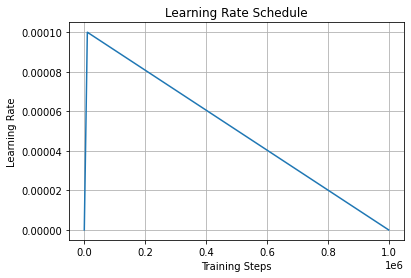

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from modules.optim_schedule import ScheduledOptim
import config

#random create one model
test_model = torch.nn.Linear(10, 1)


optimizer = Adam(test_model.parameters(), lr=config.learning_rate, betas=(config.adam_beta1, config.adam_beta2), weight_decay=config.adam_weight_decay)

lr_values = []

scheduler = ScheduledOptim(optimizer,config.warmup_steps,config.total_steps)

for _ in range(config.total_steps):
    
    # update lr
    scheduler.step_and_update_lr()
    lr = optimizer.param_groups[0]['lr']
    lr_values.append(lr)
    

# 绘制学习率曲线
plt.plot(lr_values)
plt.title('Learning Rate Schedule')
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

### 3.2 Train loop
Simple test of pretraining process.

In [5]:
print("Training Start")
for epoch in range(config.epochs):
    trainer.train(epoch)
    if epoch % config.log_freq == 0:
        trainer.save(epoch, config.trained_path)
    if test_data_loader is not None:
        trainer.test(epoch)

Training Start


EP_train:0:   0%|| 0/1 [00:00<?, ?it/s]

get_corpus_line:item: 0
get_corpus_line:item: 1
get_corpus_line:item: 2
get_corpus_line:item: 3
get_corpus_line:item: 4
get_corpus_line:item: 5
get_corpus_line:item: 6
get_corpus_line:item: 7
get_corpus_line:item: 8
get_corpus_line:item: 9
get_corpus_line:item: 10
get_corpus_line:item: 11
get_corpus_line:item: 12
get_corpus_line:item: 13
Batch 0 data: {'bert_input': tensor([[ 3,  6, 38,  ...,  0,  0,  0],
        [ 3, 25, 50,  ...,  0,  0,  0],
        [ 3,  6,  4,  ...,  0,  0,  0],
        ...,
        [ 3, 60, 31,  ...,  0,  0,  0],
        [ 3,  6, 56,  ...,  0,  0,  0],
        [ 3,  6, 27,  ...,  0,  0,  0]]), 'bert_label': tensor([[ 0,  0, 38,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  6, 49,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]]), 'segment_label': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ...

EP_train:0: 100%|| 1/1 [00:00<00:00,  1.79it/s]


{'epoch': 0, 'iter': 0, 'avg_loss': 5.259231090545654, 'avg_acc': 35.714285714285715, 'loss': 5.259231090545654}
EP0_train, avg_loss= 5.259231090545654 total_acc= 35.714285714285715
EP:0 Model Saved on: /root/autodl-tmp/bert/checkpoints/bert_self_trained_ep0.pth


EP_train:1:   0%|| 0/1 [00:00<?, ?it/s]

get_corpus_line:item: 0
get_corpus_line:item: 1
get_corpus_line:item: 2
get_corpus_line:item: 3
get_corpus_line:item: 4
get_corpus_line:item: 5
get_corpus_line:item: 6
get_corpus_line:item: 7
get_corpus_line:item: 8
get_corpus_line:item: 9
get_corpus_line:item: 10
get_corpus_line:item: 11
get_corpus_line:item: 12
get_corpus_line:item: 13
Batch 0 data: {'bert_input': tensor([[ 3,  6, 38,  ...,  0,  0,  0],
        [ 3, 25, 50,  ...,  0,  0,  0],
        [ 3,  6, 49,  ...,  0,  0,  0],
        ...,
        [ 3, 60, 31,  ...,  0,  0,  0],
        [ 3,  4, 56,  ...,  0,  0,  0],
        [ 3,  6, 27,  ...,  0,  0,  0]]), 'bert_label': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 6, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'segment_label': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0,

EP_train:1: 100%|| 1/1 [00:00<00:00,  1.59it/s]

{'epoch': 1, 'iter': 0, 'avg_loss': 5.408900260925293, 'avg_acc': 50.0, 'loss': 5.408900260925293}
EP1_train, avg_loss= 5.408900260925293 total_acc= 50.0



EP_train:2:   0%|| 0/1 [00:00<?, ?it/s]

get_corpus_line:item: 0
get_corpus_line:item: 1
get_corpus_line:item: 2
get_corpus_line:item: 3
get_corpus_line:item: 4
get_corpus_line:item: 5
get_corpus_line:item: 6
get_corpus_line:item: 7
get_corpus_line:item: 8
get_corpus_line:item: 9
get_corpus_line:item: 10
get_corpus_line:item: 11
get_corpus_line:item: 12
get_corpus_line:item: 13
Batch 0 data: {'bert_input': tensor([[ 3,  4, 38,  ...,  0,  0,  0],
        [ 3, 25, 50,  ...,  0,  0,  0],
        [ 3,  4, 49,  ...,  0,  0,  0],
        ...,
        [ 3, 60,  4,  ...,  0,  0,  0],
        [ 3,  6, 56,  ...,  0,  0,  0],
        [ 3,  4,  4,  ...,  0,  0,  0]]), 'bert_label': tensor([[ 0,  6,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  6,  0,  ...,  0,  0,  0],
        ...,
        [ 0,  0, 31,  ...,  0,  0,  0],
        [ 0,  6,  0,  ...,  0,  0,  0],
        [ 0,  6, 27,  ...,  0,  0,  0]]), 'segment_label': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ...

EP_train:2: 100%|| 1/1 [00:00<00:00,  1.64it/s]

{'epoch': 2, 'iter': 0, 'avg_loss': 5.393688201904297, 'avg_acc': 42.857142857142854, 'loss': 5.393688201904297}
EP2_train, avg_loss= 5.393688201904297 total_acc= 42.857142857142854



EP_train:3:   0%|| 0/1 [00:00<?, ?it/s]

get_corpus_line:item: 0
get_corpus_line:item: 1
get_corpus_line:item: 2
get_corpus_line:item: 3
get_corpus_line:item: 4
get_corpus_line:item: 5
get_corpus_line:item: 6
get_corpus_line:item: 7
get_corpus_line:item: 8
get_corpus_line:item: 9
get_corpus_line:item: 10
get_corpus_line:item: 11
get_corpus_line:item: 12
get_corpus_line:item: 13
Batch 0 data: {'bert_input': tensor([[ 3,  4, 38,  ...,  0,  0,  0],
        [ 3, 25, 50,  ...,  0,  0,  0],
        [ 3,  6, 49,  ...,  0,  0,  0],
        ...,
        [ 3, 60, 31,  ...,  0,  0,  0],
        [ 3,  6, 56,  ...,  0,  0,  0],
        [ 3,  6, 27,  ...,  0,  0,  0]]), 'bert_label': tensor([[0, 6, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'segment_label': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0,

EP_train:3: 100%|| 1/1 [00:00<00:00,  1.65it/s]

{'epoch': 3, 'iter': 0, 'avg_loss': 5.257310390472412, 'avg_acc': 35.714285714285715, 'loss': 5.257310390472412}
EP3_train, avg_loss= 5.257310390472412 total_acc= 35.714285714285715



EP_train:4:   0%|| 0/1 [00:00<?, ?it/s]

get_corpus_line:item: 0
get_corpus_line:item: 1
get_corpus_line:item: 2
get_corpus_line:item: 3
get_corpus_line:item: 4
get_corpus_line:item: 5
get_corpus_line:item: 6
get_corpus_line:item: 7
get_corpus_line:item: 8
get_corpus_line:item: 9
get_corpus_line:item: 10
get_corpus_line:item: 11
get_corpus_line:item: 12
get_corpus_line:item: 13
Batch 0 data: {'bert_input': tensor([[ 3,  6, 38,  ...,  0,  0,  0],
        [ 3, 25, 50,  ...,  0,  0,  0],
        [ 3,  6,  4,  ...,  0,  0,  0],
        ...,
        [ 3, 60, 31,  ...,  0,  0,  0],
        [ 3,  6, 56,  ...,  0,  0,  0],
        [ 3,  6, 27,  ...,  0,  0,  0]]), 'bert_label': tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0, 49,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]]), 'segment_label': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ...

EP_train:4: 100%|| 1/1 [00:00<00:00,  1.74it/s]

{'epoch': 4, 'iter': 0, 'avg_loss': 5.3732008934021, 'avg_acc': 35.714285714285715, 'loss': 5.3732008934021}
EP4_train, avg_loss= 5.3732008934021 total_acc= 35.714285714285715



EP_train:5:   0%|| 0/1 [00:00<?, ?it/s]

get_corpus_line:item: 0
get_corpus_line:item: 1
get_corpus_line:item: 2
get_corpus_line:item: 3
get_corpus_line:item: 4
get_corpus_line:item: 5
get_corpus_line:item: 6
get_corpus_line:item: 7
get_corpus_line:item: 8
get_corpus_line:item: 9
get_corpus_line:item: 10
get_corpus_line:item: 11
get_corpus_line:item: 12
get_corpus_line:item: 13
Batch 0 data: {'bert_input': tensor([[ 3,  6, 38,  ...,  0,  0,  0],
        [ 3, 25, 50,  ...,  0,  0,  0],
        [ 3,  6, 49,  ...,  0,  0,  0],
        ...,
        [ 3,  4, 31,  ...,  0,  0,  0],
        [ 3,  6, 56,  ...,  0,  0,  0],
        [ 3,  6, 27,  ...,  0,  0,  0]]), 'bert_label': tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  6,  0,  ...,  0,  0,  0],
        ...,
        [ 0, 60,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]]), 'segment_label': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ...

EP_train:5: 100%|| 1/1 [00:00<00:00,  1.74it/s]


{'epoch': 5, 'iter': 0, 'avg_loss': 5.015069007873535, 'avg_acc': 71.42857142857143, 'loss': 5.015069007873535}
EP5_train, avg_loss= 5.015069007873535 total_acc= 71.42857142857143
EP:5 Model Saved on: /root/autodl-tmp/bert/checkpoints/bert_self_trained_ep5.pth


EP_train:6:   0%|| 0/1 [00:00<?, ?it/s]

get_corpus_line:item: 0
get_corpus_line:item: 1
get_corpus_line:item: 2
get_corpus_line:item: 3
get_corpus_line:item: 4
get_corpus_line:item: 5
get_corpus_line:item: 6
get_corpus_line:item: 7
get_corpus_line:item: 8
get_corpus_line:item: 9
get_corpus_line:item: 10
get_corpus_line:item: 11
get_corpus_line:item: 12
get_corpus_line:item: 13
Batch 0 data: {'bert_input': tensor([[ 3,  6, 38,  ...,  0,  0,  0],
        [ 3, 25, 50,  ...,  0,  0,  0],
        [ 3,  4, 49,  ...,  0,  0,  0],
        ...,
        [ 3, 60, 31,  ...,  0,  0,  0],
        [ 3,  6, 56,  ...,  0,  0,  0],
        [ 3,  6, 27,  ...,  0,  0,  0]]), 'bert_label': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 6, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'segment_label': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0,

EP_train:6: 100%|| 1/1 [00:00<00:00,  1.73it/s]

{'epoch': 6, 'iter': 0, 'avg_loss': 5.408575534820557, 'avg_acc': 50.0, 'loss': 5.408575534820557}
EP6_train, avg_loss= 5.408575534820557 total_acc= 50.0



EP_train:7:   0%|| 0/1 [00:00<?, ?it/s]

get_corpus_line:item: 0
get_corpus_line:item: 1
get_corpus_line:item: 2
get_corpus_line:item: 3
get_corpus_line:item: 4
get_corpus_line:item: 5
get_corpus_line:item: 6
get_corpus_line:item: 7
get_corpus_line:item: 8
get_corpus_line:item: 9
get_corpus_line:item: 10
get_corpus_line:item: 11
get_corpus_line:item: 12
get_corpus_line:item: 13
Batch 0 data: {'bert_input': tensor([[ 3,  6, 38,  ...,  0,  0,  0],
        [ 3, 25, 50,  ...,  0,  0,  0],
        [ 3,  6, 49,  ...,  0,  0,  0],
        ...,
        [ 3, 60, 34,  ...,  0,  0,  0],
        [ 3,  6, 56,  ...,  0,  0,  0],
        [ 3,  6, 27,  ...,  0,  0,  0]]), 'bert_label': tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        ...,
        [ 0,  0, 31,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]]), 'segment_label': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ...

EP_train:7: 100%|| 1/1 [00:00<00:00,  1.71it/s]

{'epoch': 7, 'iter': 0, 'avg_loss': 5.3588995933532715, 'avg_acc': 35.714285714285715, 'loss': 5.3588995933532715}
EP7_train, avg_loss= 5.3588995933532715 total_acc= 35.714285714285715



EP_train:8:   0%|| 0/1 [00:00<?, ?it/s]

get_corpus_line:item: 0
get_corpus_line:item: 1
get_corpus_line:item: 2
get_corpus_line:item: 3
get_corpus_line:item: 4
get_corpus_line:item: 5
get_corpus_line:item: 6
get_corpus_line:item: 7
get_corpus_line:item: 8
get_corpus_line:item: 9
get_corpus_line:item: 10
get_corpus_line:item: 11
get_corpus_line:item: 12
get_corpus_line:item: 13
Batch 0 data: {'bert_input': tensor([[ 3,  6,  4,  ...,  0,  0,  0],
        [ 3, 25, 50,  ...,  0,  0,  0],
        [ 3,  6, 49,  ...,  0,  0,  0],
        ...,
        [ 3,  4, 31,  ...,  0,  0,  0],
        [ 3,  6, 56,  ...,  0,  0,  0],
        [ 3,  6, 27,  ...,  0,  0,  0]]), 'bert_label': tensor([[ 0,  0, 38,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        ...,
        [ 0, 60,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]]), 'segment_label': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ...

EP_train:8: 100%|| 1/1 [00:00<00:00,  1.52it/s]

{'epoch': 8, 'iter': 0, 'avg_loss': 5.175176620483398, 'avg_acc': 50.0, 'loss': 5.175176620483398}
EP8_train, avg_loss= 5.175176620483398 total_acc= 50.0



EP_train:9:   0%|| 0/1 [00:00<?, ?it/s]

get_corpus_line:item: 0
get_corpus_line:item: 1
get_corpus_line:item: 2
get_corpus_line:item: 3
get_corpus_line:item: 4
get_corpus_line:item: 5
get_corpus_line:item: 6
get_corpus_line:item: 7
get_corpus_line:item: 8
get_corpus_line:item: 9
get_corpus_line:item: 10
get_corpus_line:item: 11
get_corpus_line:item: 12
get_corpus_line:item: 13
Batch 0 data: {'bert_input': tensor([[ 3,  6, 38,  ...,  0,  0,  0],
        [ 3, 25, 50,  ...,  0,  0,  0],
        [ 3,  6, 49,  ...,  0,  0,  0],
        ...,
        [ 3, 60, 31,  ...,  0,  0,  0],
        [ 3,  4, 56,  ...,  0,  0,  0],
        [ 3,  6, 27,  ...,  0,  0,  0]]), 'bert_label': tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  6, 56,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]]), 'segment_label': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ...

EP_train:9: 100%|| 1/1 [00:00<00:00,  1.75it/s]

{'epoch': 9, 'iter': 0, 'avg_loss': 5.058281898498535, 'avg_acc': 50.0, 'loss': 5.058281898498535}
EP9_train, avg_loss= 5.058281898498535 total_acc= 50.0



EP_train:10:   0%|| 0/1 [00:00<?, ?it/s]

get_corpus_line:item: 0
get_corpus_line:item: 1
get_corpus_line:item: 2
get_corpus_line:item: 3
get_corpus_line:item: 4
get_corpus_line:item: 5
get_corpus_line:item: 6
get_corpus_line:item: 7
get_corpus_line:item: 8
get_corpus_line:item: 9
get_corpus_line:item: 10
get_corpus_line:item: 11
get_corpus_line:item: 12
get_corpus_line:item: 13
Batch 0 data: {'bert_input': tensor([[ 3,  4, 38,  ...,  0,  0,  0],
        [ 3, 25, 50,  ...,  0,  0,  0],
        [ 3,  6, 49,  ...,  0,  0,  0],
        ...,
        [ 3, 60, 31,  ...,  0,  0,  0],
        [ 3,  6, 56,  ...,  0,  0,  0],
        [ 3,  6, 27,  ...,  0,  0,  0]]), 'bert_label': tensor([[0, 6, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'segment_label': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0,

EP_train:10: 100%|| 1/1 [00:00<00:00,  1.88it/s]


{'epoch': 10, 'iter': 0, 'avg_loss': 4.9748125076293945, 'avg_acc': 42.857142857142854, 'loss': 4.9748125076293945}
EP10_train, avg_loss= 4.9748125076293945 total_acc= 42.857142857142854
EP:10 Model Saved on: /root/autodl-tmp/bert/checkpoints/bert_self_trained_ep10.pth
